In [1]:
import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(13)

Using TensorFlow backend.


In [10]:
data = pd.read_csv('train.csv', sep=';')

In [11]:
data.head()

,predicate,question
0,http://dbpedia.org/ontology/distributor,what movie is produced by warner bros.
1,http://purl.org/linguistics/gold/hypernym,What is don graham known as?
2,http://dbpedia.org/ontology/location,what's there to see in columbus
3,http://dbpedia.org/ontology/birthPlace,who is a musician born in detroit
4,http://dbpedia.org/ontology/hometown,Which city did the artist ryna originate in


In [12]:
from sklearn import preprocessing

In [13]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(list(data['predicate']))
data['predicate'] = label_encoder.transform(list(data['predicate'].values.astype('str')))

In [16]:
prep_queries = data.question

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(prep_queries)
sequences = tokenizer.texts_to_sequences(prep_queries)
sequences_lenghts = np.array(list(map(lambda x: len(x), sequences)))
word_index = tokenizer.word_index
print('{0} уникальных токенов.'.format(len(word_index)))

25186 уникальных токенов.


In [18]:
from collections import Counter

Counter(tokenizer.word_counts).most_common(10)

[('what', 16341),
 ('is', 15539),
 ('the', 10149),
 ('of', 9334),
 ('in', 6555),
 ('a', 5209),
 ('was', 4451),
 ('who', 3846),
 ('which', 3784),
 ('where', 3172)]

In [20]:
import pickle
pickle.dump(tokenizer, open("Tokenizer", 'wb'))

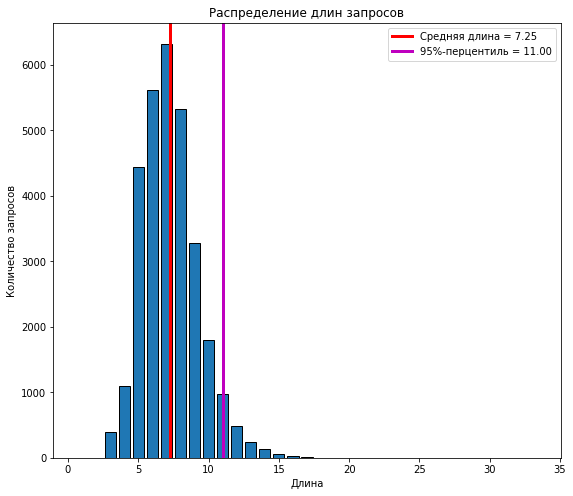

In [21]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(sequences_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(sequences_lenghts), 
            c="r", lw=3, 
            label="Средняя длина = {:.2f}".format(np.mean(sequences_lenghts)))
plt.axvline(np.percentile(sequences_lenghts, 95), 
            c="m", lw=3, 
            label="95%-перцентиль = {:.2f}".format(np.percentile(sequences_lenghts, 95)))
plt.xlabel("Длина")
plt.ylabel("Количество запросов")
plt.title("Распределение длин запросов")
plt.legend()

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
onehot_encoder = OneHotEncoder(sparse=False)

In [24]:
X = pad_sequences(sequences, maxlen=11)

labels = np.array(data.predicate)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', labels.shape)
labels = labels.reshape(len(labels), 1)

Y = onehot_encoder.fit_transform(labels)

print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=True)

Shape of data tensor: (30186, 11)
Shape of label tensor: (30186,)
(30186, 100)


In [25]:
pickle.dump(onehot_encoder, open("OneHotEncoder", 'wb'))

In [27]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
import tqdm

In [29]:
wv = Word2Vec([q.split() for q in prep_queries], size=300, window=5,min_count=1)
wv.train([q.split() for q in prep_queries],epochs=100,total_examples=wv.corpus_count)
wv.save("word2vec")

#wv = Word2Vec.load("bin/word2vec") #тренируем свои потому, что предобученные содержат меньше половины нужных слов

In [30]:
zeros = []
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm.tqdm(word_index.items()):
    if word in wv.wv.vocab:
        embedding_matrix[i] = wv[word]
    else:
        zeros.append(word)

100%|██████████| 25186/25186 [00:00<00:00, 108778.39it/s]


In [37]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=11,
                            trainable=True)

In [38]:
from keras.layers import Input, Conv1D, Dense, MaxPooling1D,Dropout,LSTM
from keras.models import Model, Sequential, load_model

In [39]:
model = Sequential()

model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150))
model.add(Dense(np.unique(labels).shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 11, 300)           7556100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 128)            192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               167400    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               15100     
Total params: 7,930,728
Trainable params: 7,930,728
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=14, batch_size=64)

model.save('CNN')

Train on 20224 samples, validate on 9962 samples
Epoch 1/14
20224/20224 [==============================] - 50s 2ms/step - loss: 1.8136 - acc: 0.5690 - val_loss: 1.2762 - val_acc: 0.6656
Epoch 2/14
20224/20224 [==============================] - 52s 3ms/step - loss: 1.1455 - acc: 0.6841 - val_loss: 1.1320 - val_acc: 0.6880
Epoch 3/14
20224/20224 [==============================] - 52s 3ms/step - loss: 0.9824 - acc: 0.7180 - val_loss: 1.0719 - val_acc: 0.6938
Epoch 4/14
20224/20224 [==============================] - 52s 3ms/step - loss: 0.8883 - acc: 0.7387 - val_loss: 1.0302 - val_acc: 0.7032
Epoch 5/14
20224/20224 [==============================] - 52s 3ms/step - loss: 0.8051 - acc: 0.7593 - val_loss: 1.0406 - val_acc: 0.6977
Epoch 6/14
20224/20224 [==============================] - 51s 3ms/step - loss: 0.7416 - acc: 0.7751 - val_loss: 1.0095 - val_acc: 0.7076
Epoch 7/14
20224/20224 [==============================] - 60s 3ms/step - loss: 0.6917 - acc: 0.7873 - val_loss: 1.0114 - val_acc:

In [41]:
y_pred_onehot = model.predict(X_test)

In [42]:
y_pred = []
y_val = []
for i in range(y_pred_onehot.shape[0]):
    y_pred.append(np.argmax(y_pred_onehot[i]))
    y_val.append(np.argmax(y_test[i]))

In [43]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [44]:
print(precision_score(y_val,y_pred,average='weighted'),
          recall_score(y_val,y_pred,average='weighted'),f1_score(y_val,y_pred,average='weighted'))

0.7071456056983277 0.7113029512146155 0.69933915306686


In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(prep_queries)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.33, random_state=42,shuffle=True)

In [123]:
len(tfidf.get_feature_names())

14898

In [124]:
simple_model = Sequential()

simple_model.add(Dense(512, input_shape=(X_train.shape[1],),activation='relu'))
simple_model.add(Dense(212,activation='softmax'))
simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1])

simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               7628288   
_________________________________________________________________
dense_19 (Dense)             (None, 212)               108756    
Total params: 7,737,044
Trainable params: 7,737,044
Non-trainable params: 0
_________________________________________________________________


In [127]:
simple_model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=32)

simple_model.save('bin/SimpleNN')

Train on 16234 samples, validate on 7997 samples
Epoch 1/2
16234/16234 [==============================] - 87s 5ms/step - loss: 0.0419 - acc: 0.9952 - f1: 0.9949 - val_loss: 1.2286 - val_acc: 0.6768 - val_f1: 0.6762
Epoch 2/2
16234/16234 [==============================] - 87s 5ms/step - loss: 0.0305 - acc: 0.9964 - f1: 0.9960 - val_loss: 1.2869 - val_acc: 0.6724 - val_f1: 0.6714


In [128]:
y_pred_onehot = simple_model.predict(X_test)
y_pred = []
y_val = []
for i in range(y_pred_onehot.shape[0]):
    y_pred.append(np.argmax(y_pred_onehot[i]))
    y_val.append(np.argmax(y_test[i]))
print(precision_score(y_val,y_pred,average='weighted'),
      recall_score(y_val,y_pred,average='weighted'),f1_score(y_val,y_pred,average='weighted'))

0.702748452805034 0.6723771414280355 0.6724745873695136
